In [1]:
import sys
import os

# Add the path to the directory containing your module
sys.path.append(os.path.abspath('/projectnb/textconv/dgwave/AudioSCC/data'))
sys.path.append(os.path.abspath('/projectnb/textconv/dgwave/AudioSCC/losses'))
sys.path.append(os.path.abspath('/projectnb/textconv/dgwave/AudioSCC/models'))

In [2]:
from dataloader import WaveformDatasetPreload
from sampler import RandomConsecutiveSampler
from losses import ConsecutiveDifferenceHigherOrderLossBatch, ConsecutiveDifferenceHigherOrderLoss
from SwissArmyModel_dev import SeqModel, SwissArmyLayer, SeqEncoder


import numpy as np
import torch
from tqdm import tqdm 
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

In [3]:
# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the first available GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU found, using CPU.")

Using GPU: Tesla V100-SXM2-16GB


In [4]:
class PairwiseDifferenceLoss(nn.Module):
    def __init__(self, consecutive_size, device, scale_up=1000):
        super(PairwiseDifferenceLoss, self).__init__()
        self.consecutive_size = consecutive_size
        self.device = device
        self.scale_up  = scale_up

    def forward(self, data, labels):
        
        ####YOU HAVE TO MAKE THIS batch by consec!!
        data = data.view(-1, self.consecutive_size)
        labels = labels.view(-1, self.consecutive_size)
        batch_size = data.shape[0]
        #print(data.shape, labels.shape)
        # Expand the tensor to compute pairwise differences
        data_expanded1 = data.unsqueeze(2).expand(batch_size, self.consecutive_size, self.consecutive_size)
        data_expanded2 = data.unsqueeze(1).expand(batch_size, self.consecutive_size, self.consecutive_size)
        
        # Compute differences between data and labels
        data_differences = (data_expanded1 - data_expanded2)
        #print(data_expanded1 == data_expanded2)
        #print(data_expanded1,data_expanded2, data_differences)
        # Compute differences with the labels
        labels_expanded1 = labels.unsqueeze(2).expand(batch_size, self.consecutive_size, self.consecutive_size)
        labels_expanded2 = labels.unsqueeze(1).expand(batch_size, self.consecutive_size, self.consecutive_size)
        label_differences = (labels_expanded1 - labels_expanded2)
        #print(labels_expanded1,labels_expanded1, label_differences)
        
        #mask = torch.triu(torch.ones(batch_size, self.consecutive_size, self.consecutive_size), diagonal=1).to(self.device)
        
        differences = (( data_differences*self.scale_up - label_differences*self.scale_up)**2)
        #print(differences.shape)
        # Apply a mask to ignore upper triangle
        
       
        #print(differences)
        # Compute the mean to return a scalar loss
        loss = differences.mean()
        
        return loss


In [5]:
t = torch.tensor([[1,2,3,4,5,6]]).to(float)
t2 = torch.tensor([[1.05,2.2,3.1,4.2,5.1,6.0]]).to(float)
pd = PairwiseDifferenceLoss(3, "cpu")
pd(t,t2)

tensor(10555.5487, dtype=torch.float64)

In [6]:
def generate_sine_tensor(num_bits, length):
    # Create an array of integers from 0 to length - 1
    t = np.arange(length)
    # Generate the sine waves for each bit
    sine_tensor = np.zeros((length, num_bits))  # Initialize the tensor
    
    for i in range(num_bits):
        frequency = (np.pi / (2 ** i))  # Calculate frequency based on the number of bits
        sine_tensor[:, i] = np.cos(frequency * (t))  # Fill the tensor with sine values

    return sine_tensor

In [7]:
num_bits = 30
max_len = 50_000
seq_bits = 10
seq_max_len = 2
directory = "/projectnb/textconv/dgwave/AudioSCC/data/digits_two/"
terminal_pad = 11
seq_vocab_len = 10

# Sampler setup as before
batch_size = 500
consecutive_size = 50

In [8]:
t_input = torch.tensor(generate_sine_tensor(num_bits,max_len)).float()
print(t_input.shape)

seq_t = torch.tensor(generate_sine_tensor(seq_bits,seq_max_len)).float()
print(seq_t.shape)

torch.Size([50000, 30])
torch.Size([2, 10])


In [9]:
t_input

tensor([[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        [-1.0000e+00,  6.1232e-17,  7.0711e-01,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        [ 1.0000e+00, -1.0000e+00,  6.1232e-17,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        ...,
        [-1.0000e+00,  8.0013e-13, -7.0711e-01,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        [ 1.0000e+00, -1.0000e+00, -1.6817e-12,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        [-1.0000e+00, -5.9268e-12,  7.0711e-01,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00]])

In [10]:
seq_t

tensor([[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
          1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00],
        [-1.0000e+00,  6.1232e-17,  7.0711e-01,  9.2388e-01,  9.8079e-01,
          9.9518e-01,  9.9880e-01,  9.9970e-01,  9.9992e-01,  9.9998e-01]])

In [11]:
dataset = WaveformDatasetPreload(directory, t_input, max_len, terminal_pad, seq_vocab_len, seq_max_len, seq_t)

 


sampler = RandomConsecutiveSampler(dataset, batch_size, consecutive_size)

# DataLoader
dataloader = DataLoader(dataset, batch_sampler=sampler, num_workers=4)

In [12]:
iteration = 0

for batch in dataloader:
    wav_data, t_step, target, file_idx, seq_inputs = batch #right now this wraps arround, just fyi.  not sure its a bad thing.

    print("Waveform data:", wav_data.shape)
    print("Time step:", t_step.shape)
    print("Target tensor:", target.shape)
    print("File index:", file_idx.shape)
    print("File index:", seq_inputs.shape)
    print(t_step[0])
    #print(wav_data)
    #print(prev_target)
    iteration = iteration + 1
    if iteration > 10:
        break
    

Waveform data: torch.Size([25000, 1])
Time step: torch.Size([25000, 30])
Target tensor: torch.Size([25000, 1])
File index: torch.Size([25000, 2])
File index: torch.Size([25000, 2, 10])
tensor([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1])
Waveform data: torch.Size([25000, 1])
Time step: torch.Size([25000, 30])
Target tensor: torch.Size([25000, 1])
File index: torch.Size([25000, 2])
File index: torch.Size([25000, 2, 10])
tensor([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1])
Waveform data: torch.Size([25000, 1])
Time step: torch.Size([25000, 30])
Target tensor: torch.Size([25000, 1])
File index: torch.Size([25000, 2])
File index: torch.Size([25000, 2, 10])
tensor([ 1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1])
Waveform data: torch.Size([25000, 

In [13]:

config = {
    't_seq_bits': seq_bits,  # Example value for the input bit size
    't_seq_len': seq_max_len,    # Example value for the sequence length
    't_bits': num_bits,      # Example value for the bits used in the decoder

    'encoder': {
        't_layer_dim': 0,               # Example hidden layer dimension for encoder
        't_num_layers': 0,                # Example number of layers in the encoder's initial layer
        'fc_layers': 1,                   # Example number of fully connected layers in the encoder
        'encoder_layers': 1,              # Example number of encoder layers
        'one_hot_vocab_len': 10,          # Vocabulary size for one-hot encoding
        'one_hot_embedding_dim': 256,       # Embedding dimension for one-hot encoding
        'output_dim':128
    },

    'decoder': {
        't_layer_dim': 0,                # Example hidden layer dimension for decoder
        't_num_layers': 0,                # Example number of layers in the decoder's initial layer
        'fc_layers': 1,                   # Example number of fully connected layers in the decoder
        'decoder_layers': 1
    },

    'output': {
        'mse_output_layers': 5,           # Number of layers in the MSE output head
        'mse_dim': 256,                     # Hidden dimension for the MSE output head
        'bce_output_layers': 1,            # Number of layers in the BCE output head
        'bce_dim': 10                     # Hidden dimension for the BCE output head
    }
}


In [14]:
model = SeqModel(config)

In [15]:
model.to(device)


SeqModel(
  (encoder): SeqEncoder(
    (initial_layer): SwissArmyLayer(
      (t_layers): ModuleList()
      (embedding): Embedding(11, 256, padding_idx=10)
      (layers): ModuleList(
        (0): Linear(in_features=266, out_features=128, bias=True)
      )
    )
    (encoder_layers): ModuleList(
      (0): SwissArmyLayer(
        (t_layers): ModuleList()
        (embedding): Embedding(11, 256, padding_idx=10)
        (layers): ModuleList(
          (0): Linear(in_features=394, out_features=128, bias=True)
        )
      )
    )
  )
  (decoder): SeqDecoder(
    (decoder_layers): ModuleList(
      (0): SwissArmyLayer(
        (t_layers): ModuleList()
        (layers): ModuleList(
          (0): Linear(in_features=158, out_features=158, bias=True)
        )
      )
    )
  )
  (mse_head): Sequential(
    (0): Linear(in_features=158, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256,

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
prev_target_list = []
mse_loss_fn = nn.MSELoss()
bce_loss_fn = nn.BCELoss()
cdifb_loss = ConsecutiveDifferenceHigherOrderLossBatch(consecutive_size,order=3)
cdif_loss = ConsecutiveDifferenceHigherOrderLoss(consecutive_size,order=3)
pd = PairwiseDifferenceLoss(consecutive_size, device, scale_up = 100_000)
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    #for batch in dataloader:
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        wav_data, t_step, target, file_idx, seq_inputs = batch
        wav_data = wav_data.to(device)
        t_step = t_step.to(device)
        target = target.to(device)
        file_idx = file_idx.to(device)
        seq_inputs = seq_inputs.to(device)
        
        bce_output, mse_output = model(seq_inputs,file_idx,t_step)
        # Compute losses
        #mse_loss = mse_loss_fn(mse_output*target, wav_data)  # Assuming the target is for MSE # is this accomplishing what i want?
        #bce_loss = bce_loss_fn(bce_output, target)  # Assuming the target is for BCE
        #cdif = cdif_loss(mse_output*target, wav_data)
        #bc = bc_loss(outputs, targets)
        #cdif_b = cdifb_loss(mse_output*target, wav_data)
        
        total_loss = pd(mse_output*target, wav_data)
        # Combine losses (you can weight them if needed)
        #total_loss = 0.1*mse_loss + 0.1*bce_loss + 0.8*cdif  + 0.3*cdif_b #mess with mse
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
    # Print progress for each epoch
    #print(f"Epoch {epoch+1}/{num_epochs} MSE: {mse_loss.item():.6f} BCE: {bce_loss.item():.6f} CDIF: {cdif.item():.6f} CDIFB: {cdif_b.item():.6f}  Total Loss: {total_loss.item():.8f}")
    print(f"Epoch {epoch+1}/{num_epochs} pd: {total_loss.item():.8f}")
    torch.save(model, "better_embedder_8.pth")
print("all done sweetheart <3")

Epoch 1/10: 2249it [14:16,  2.63it/s]                          


Epoch 1/10 pd: 0.48665553


Epoch 2/10: 2249it [13:55,  2.69it/s]                          


Epoch 2/10 pd: 0.08140555


Epoch 3/10: 2249it [16:15,  2.31it/s]                          


Epoch 3/10 pd: 0.06974880


Epoch 4/10: 2249it [16:19,  2.30it/s]                          


Epoch 4/10 pd: 0.00672385


Epoch 5/10: 2249it [16:30,  2.27it/s]                          


Epoch 5/10 pd: 0.00199081


Epoch 6/10: 2249it [18:46,  2.00it/s]                          


Epoch 6/10 pd: 0.02123957


Epoch 7/10:  70%|██████▉   | 1573/2248 [10:19<04:14,  2.65it/s]

In [16]:
##i need inference and then a noise term for the training prev_pred input.  
#model = torch.load("better_embedder_2.pth") ## got 0.01193226
#model = torch.load("better_embedder_3.pth") ## 8 layer encoder.  nothing amazing.
#model = torch.load("better_embedder_4.pth") ## 2 layer encoder, 1 layer decoder, small af.
#model = torch.load("better_embedder_5.pth") #this is interesting.  it has some weird stuff, but i think seq bits might be busted.
#model = torch.load("better_embedder_6.pth")
#model = torch.load("better_embedder_7.pth") ##this is with the new loss but i upped the lr
model = torch.load("better_embedder_8.pth")
#model.eval()

In [74]:
from scipy.io import wavfile
file_path = '/projectnb/textconv/dgwave/AudioSCC/data/data_files/011.wav'
sample_rate, data_test = wavfile.read(file_path)
sample_rate

24000

In [75]:
digits = "56"

model.eval()
rep = t_input.shape[0] #this is good, 
input_seq_1 = seq_t #[:-1]

file = [int(char) for char in digits] 
input_seq_1[len(file):] = 0

file = file + [10] * (seq_max_len - len(file))
file = torch.tensor(file)
print(file, file.shape)
file = file.unsqueeze(0).repeat(rep,1)
input_seq_eval = input_seq_1.unsqueeze(0).repeat(rep, 1,1)

print(file.shape,input_seq_eval.shape, t_input.shape )


tensor([5, 6]) torch.Size([2])
torch.Size([50000, 2]) torch.Size([50000, 2, 10]) torch.Size([50000, 30])


In [76]:
seq_t

tensor([[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
          1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00],
        [-1.0000e+00,  6.1232e-17,  7.0711e-01,  9.2388e-01,  9.8079e-01,
          9.9518e-01,  9.9880e-01,  9.9970e-01,  9.9992e-01,  9.9998e-01]])

In [77]:
# Assuming input shapes: (batch_size, ...)
# Define your eval batch size
eval_batch_size = 200

# Initialize lists to store outputs
bce_outputs = []
mse_outputs = []

# Get the total number of batches
total_batches = (file.shape[0] + eval_batch_size - 1) // eval_batch_size

# Loop over batches
for i in range(total_batches):
    # Define the start and end of the batch
    start_idx = i * eval_batch_size
    end_idx = min((i + 1) * eval_batch_size, file.shape[0])

    # Slice the batch from each input
    batch_file = file[start_idx:end_idx]
    batch_file = batch_file.to(device)
    batch_input_seq_eval = input_seq_eval[start_idx:end_idx]
    batch_input_seq_eval = batch_input_seq_eval.to(device)
    batch_t_input = t_input[start_idx:end_idx]
    batch_t_input = batch_t_input.to(device)

    # Run the model in evaluation mode (assuming the model is in eval mode already)
    with torch.no_grad():  # Disable gradient calculation for evaluation
        bce_output, mse_output = model(batch_input_seq_eval, batch_file, batch_t_input)
    
    # Append the outputs
    bce_outputs.append(bce_output)
    mse_outputs.append(mse_output)

# Optionally, concatenate the outputs into single tensors
bce_outputs = torch.cat(bce_outputs, dim=0)
mse_outputs = torch.cat(mse_outputs, dim=0)

# Now bce_outputs and mse_outputs contain the model outputs for all batches


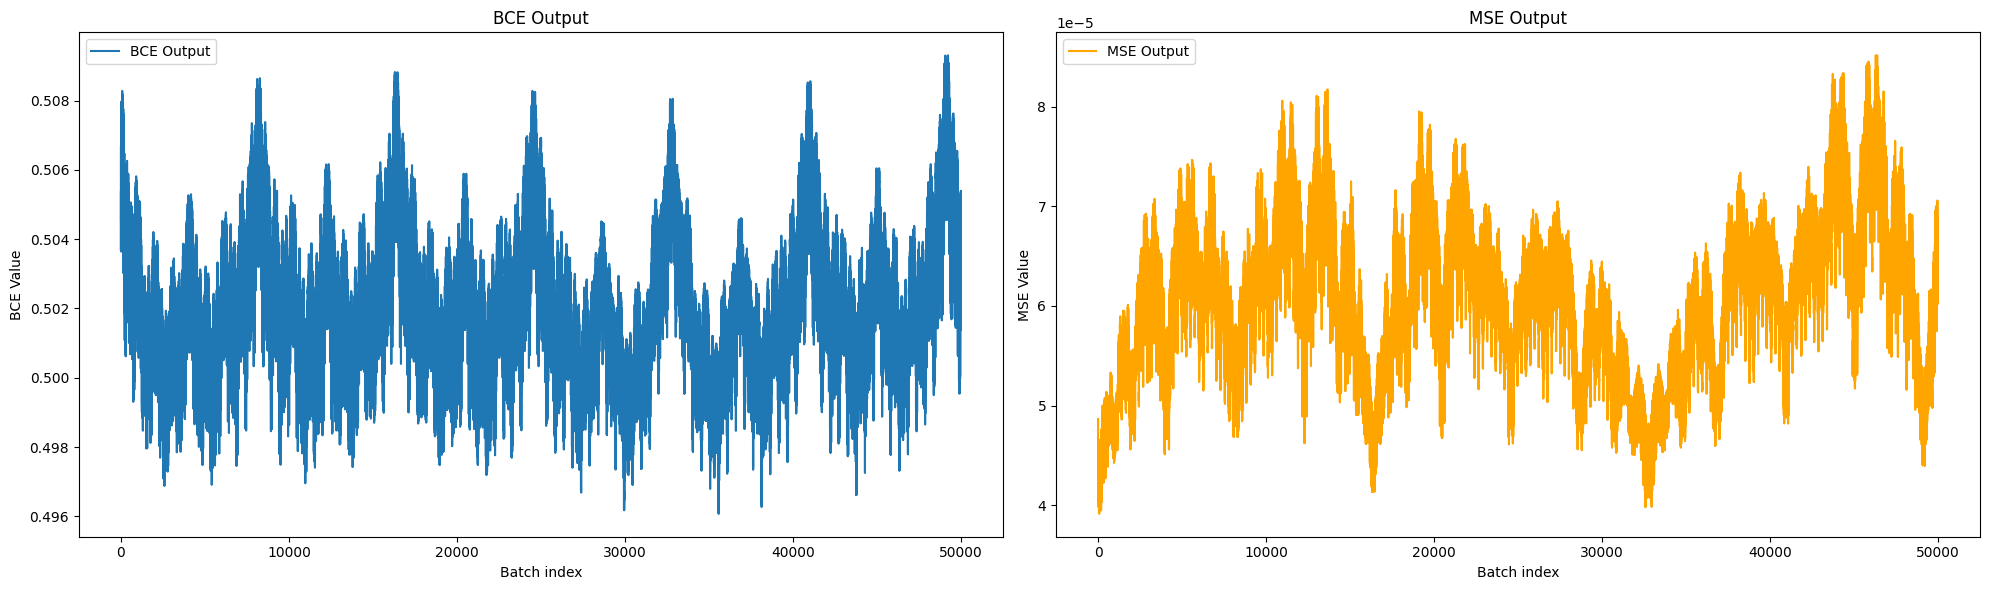

In [78]:

import matplotlib.pyplot as plt



# Create a figure and plot both outputs
plt.figure(figsize=(20, 6))

# Plot BCE outputs
plt.subplot(1, 2, 1)
plt.plot(bce_outputs.cpu().numpy(), label='BCE Output')
plt.title('BCE Output')
plt.xlabel('Batch index')
plt.ylabel('BCE Value')
plt.legend()

# Plot MSE outputs
plt.subplot(1, 2, 2)
plt.plot(mse_outputs.cpu().numpy(), label='MSE Output', color='orange')
plt.title('MSE Output')
plt.xlabel('Batch index')
plt.ylabel('MSE Value')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [79]:
import torch
import numpy as np
from scipy.io.wavfile import write


def tensor_to_wav(tensor, filename, sample_rate=44100,cut_off=-1 ):
    # Convert tensor to numpy array and detach if needed
    data = tensor.detach().cpu().numpy()[:cut_off]
    # Normalize to the range [-1, 1]
    #data = data / np.max(np.abs(data))

    # Convert to 16-bit PCM format (values between -32768 and 32767)
    data_int16 = np.int16(data * 32768)

    # Write the .wav file
    write(filename, sample_rate, data_int16)
    print(f"Saved as {filename}")

# Example usage with your model predictions (assuming predictions are in range -1 to 1):
# predictions is the output tensor from the model
tensor_to_wav(mse_outputs, "test_mult_first_bad.wav",sample_rate)

Saved as test_mult_first_bad.wav


In [80]:
from IPython.display import Audio

# Play the .wav file
Audio("test_mult_first_bad.wav")